# Simple Tickets prediction with DNN

Goal: Predict the number of tickets requested by different clients

Here we demonstrate how a neural network can be used in very simple projects originally designed for linear models

Data taken from [Udacity's problem solving with advanced analytics](https://www.udacity.com/course/problem-solving-with-advanced-analytics--ud976)

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import helper

helper.reproducible(seed=9)
sns.set()

Using TensorFlow backend.


## Load and prepare the data

In [2]:
train_data_path = 'data/simple_tickets_data.csv'
df = pd.read_csv(train_data_path)
original_df=df
print(df.shape)
df.head()

(300, 5)


,Client ID,Average Number of Tickets,Number of Employees,Value of Contract,Industry
0,TK669,90,561,200000,Retail
1,EY859,85,530,200000,Retail
2,TN571,5,82,25000,Manufacturing
3,LJ675,82,491,225000,Manufacturing
4,KH713,12,230,75000,Services


In [3]:
targets = ['Average Number of Tickets']
features = ['Number of Employees', 'Value of Contract', 'Industry']

df = df[features + targets]

# convert dataframe values to numerical
# df = df.apply(pd.to_numeric, errors='coerce')

categorical = [feat for feat in features if df[feat].dtype == 'object']
numerical = [feat for feat in features if df[feat].dtype != 'object']

print("Categorical features: \t{}".format(categorical))
print("Numerical features: \t{}".format(numerical))


# Reeplace NaN values by mean (numerical) or 'No Data' (categorical) 
df = df.fillna(df[numerical].mean())
df = df.replace(np.nan, 'No Data', regex=True)

#df[numerical].dtypes

Categorical features: 	['Industry']
Numerical features: 	['Number of Employees', 'Value of Contract']


### Visualize data

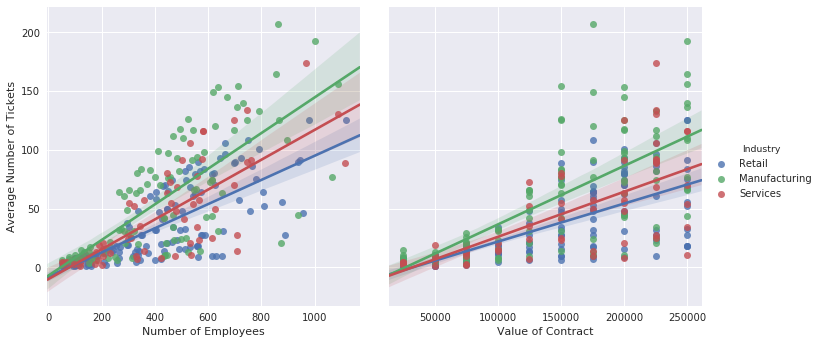

In [4]:
g = sns.PairGrid(df, y_vars=targets, x_vars=numerical, size=5, hue='Industry')
g.map(sns.regplot).add_legend()

#sns.pairplot(df, hue = 'Industry', vars=['Number of Employees', 'Value of Contract'] + targets, size = 4)

The plotting shows that a linear model could be enough to make predictions

### Create dummy variables

In [5]:
dummy_fields = categorical

# Process categorical variables 
dummy_fields = [d for d in dummy_fields if d in df]
for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    df = pd.concat([df, dummies], axis=1)

df = df.drop(dummy_fields, axis='columns')

features_list = list(df.drop(targets, axis=1))
print(features_list)
df.head()

['Number of Employees', 'Value of Contract', 'Industry_Manufacturing', 'Industry_Retail', 'Industry_Services']


,Number of Employees,Value of Contract,Average Number of Tickets,Industry_Manufacturing,Industry_Retail,Industry_Services
0,561,200000,90,0,1,0
1,530,200000,85,0,1,0
2,82,25000,5,1,0,0
3,491,225000,82,1,0,0
4,230,75000,12,0,0,1


### Scaling variables
The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = numerical

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for f in quant_features:
    mean, std = df[f].mean(), df[f].std()
    scaled_features[f] = [mean, std]
    df.loc[:, f] = (df[f] - mean)/std

scaled_targets = {}
for f in targets:
    mean, std = df[f].mean(), df[f].std()
    scaled_targets[f] = [mean, std]
    df.loc[:, f] = (df[f] - mean)/std    
    
df.head()

,Number of Employees,Value of Contract,Average Number of Tickets,Industry_Manufacturing,Industry_Retail,Industry_Services
0,0.569857,0.802960,1.066255,0,1,0
1,0.443566,0.802960,0.948835,0,1,0
2,-1.381540,-1.623250,-0.929891,1,0,0
3,0.284684,1.149562,0.878383,1,0,0
4,-0.778603,-0.930047,-0.765502,0,0,1


### Split the data

No testing set will be used here

In [7]:
# Separate the data into features and targets (x=features, y=targets)
x_train, y_train = df.drop(targets, axis=1).values, df[targets].values

## Deep Neural Network
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 36.0
Trainable params: 36
Non-trainable params: 0.0
_________________________________________________________________

Training ....
CPU times: user 1.66 s, sys: 148 ms, total: 1.81 s
Wall time: 1.47 s


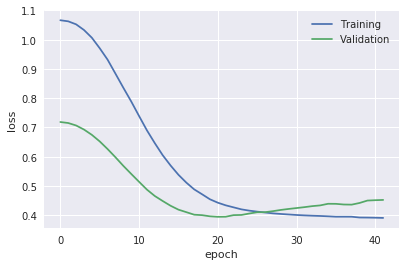


Training loss:  	0.3915
Validation loss: 	0.4529

Model saved at models/simple_tickets.h5


In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout

nodes = x_train.shape[1]
weights = keras.initializers.RandomNormal(stddev=0.001)

model = Sequential()
model.add(Dense(nodes, input_dim=x_train.shape[1], activation='relu',
               kernel_initializer=weights,
               bias_initializer = weights))
model.add(Dense(1, activation=None,
               kernel_initializer = weights,
               bias_initializer = weights))
model.summary()

model.compile(loss='mean_squared_error', optimizer='adam')

print('\nTraining ....')
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0)]
% time history = model.fit(x_train, y_train, epochs=500, batch_size=16, verbose=0, validation_split=0.2, callbacks=callbacks)
helper.show_training(history)

model_path = os.path.join("models", "simple_tickets.h5")
model.save(model_path)
print("\nModel saved at",model_path)

### Evaluate the model

In [9]:
model = keras.models.load_model(model_path)
print("Model loaded:", model_path)

# score = model.evaluate(x_train, y_train, verbose=0)
# print("\n Loss: {:.4f}".format(score))

target_mean = scaled_targets['Average Number of Tickets'][0]
target_std = scaled_targets['Average Number of Tickets'][1]

pred = model.predict(x_train, verbose=0)
restore_pred = pred * target_std + target_mean
restore_pred = restore_pred.round()
pred_df = pd.DataFrame({'Predicted Tickets': np.squeeze(restore_pred)})

extended_df = pd.concat([original_df, pred_df], axis=1)
extended_df['Prediction error (%)'] = ((extended_df['Predicted Tickets'] - extended_df['Average Number of Tickets']) * 100 /  
                                       extended_df['Average Number of Tickets']).round(1)
extended_df.head()


Model loaded: models/simple_tickets.h5


,Client ID,Average Number of Tickets,Number of Employees,Value of Contract,Industry,Predicted Tickets,Prediction error (%)
0,TK669,90,561,200000,Retail,59.0,-34.4
1,EY859,85,530,200000,Retail,55.0,-35.3
2,TN571,5,82,25000,Manufacturing,5.0,0.0
3,LJ675,82,491,225000,Manufacturing,90.0,9.8
4,KH713,12,230,75000,Services,11.0,-8.3


The prediction error (%) can be especially high when the number of tickets is low; the absolute error could be a better indicator here. 

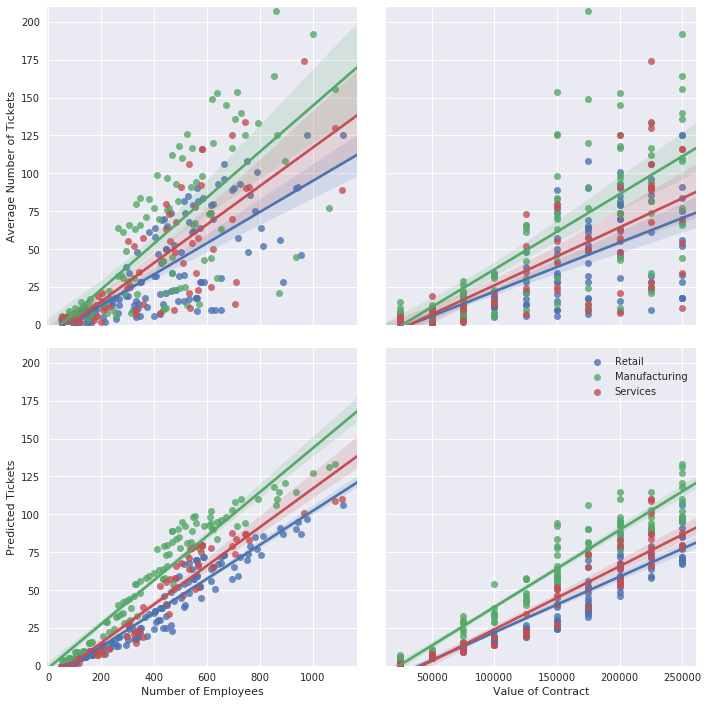

In [10]:
y = ['Average Number of Tickets', 'Predicted Tickets']
g = sns.PairGrid(extended_df, y_vars=y, x_vars=numerical, size=5, hue = 'Industry')
g.map(sns.regplot)
g.set(ylim=(0, 210))
plt.legend()

Top: Actual data. Bottom: Tickets predicted from model

Prediction error:
Mean: 	 56.42%
Stddev:  150.14%


(-600, 600)

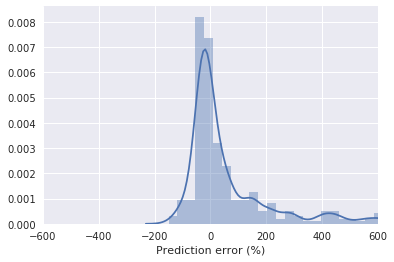

In [11]:
pred_error = extended_df['Prediction error (%)']

print("Prediction error:")
print("Mean: \t {:.2f}%".format(pred_error.mean()))
print("Stddev:  {:.2f}%".format(pred_error.std()))

sns.distplot(pred_error)
plt.xlim(xmin=-600, xmax=600)

The model still fails in many cases, especially considering it was trained with the same clients we are evaluating here. Because of the high error when the the requestes tickets are close to 0, the model predicted 1.5 times more tickets as an average.

In [12]:
# New Single Prediction:

# print(features_list)
# input data: [Employees, Value of contract, Industry_Manufacturing, Industry_Retail, Industry_Services]

employees = 750
value_of_contract = 13000
industry_manufacturing = 1
industry_retail = 0
industry_services = 0

single_data = [employees, value_of_contract, industry_manufacturing, industry_retail, industry_services]

# normalize single data
for idx, f in enumerate(quant_features):
    single_data[idx] = (single_data[idx]  - scaled_features[f][0])/scaled_features[f][1]

single_pred = model.predict(np.array([single_data]))    
single_pred = single_pred * target_std + target_mean
single_pred = single_pred.round()
print('Predicted Number of Tickets: {}'.format(single_pred[0,0]))

Predicted Number of Tickets: 55.0


### Compare to Simple Linear regression 

Prediction error:
Mean: 	 24.54%
Stddev:  217.58%


(-600, 600)

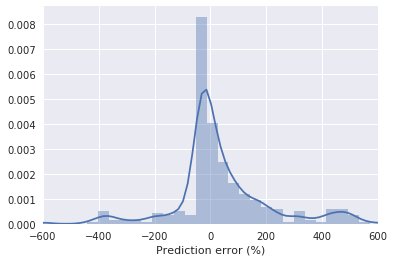

In [13]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train, y_train)
lin_pred = reg.predict(x_train)

restore_lin_pred = lin_pred * target_std + target_mean
restore_lin_pred = restore_lin_pred.round()
lin_pred_df = pd.DataFrame({'Predicted Tickets': np.squeeze(restore_lin_pred)})

extended_lin_df = pd.concat([original_df, lin_pred_df], axis=1)
extended_lin_df['Prediction error (%)'] = ((extended_lin_df['Predicted Tickets'] - extended_lin_df['Average Number of Tickets']) * 100 /  
                                       extended_lin_df['Average Number of Tickets']).round(1)

lin_pred_error = extended_lin_df['Prediction error (%)']

print("Prediction error:")
print("Mean: \t {:.2f}%".format(lin_pred_error.mean()))
print("Stddev:  {:.2f}%".format(lin_pred_error.std()))

sns.distplot(lin_pred_error)
plt.xlim(xmin=-600, xmax=600)

The standard deviation of the error is higher with the linear model. The mean of the error is closer to zero;  this can be explained as the highest errors (>= 400%) are more equilibrated on both sides of the error distribution.